# Forbes' 2025 Global 2000

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. Web Scraping

Site: https://www.forbes.com/lists/global2000/      
We will be scraping the table records listing the top 2000 public companies in the world.

In [ ]:
base_url = "https://www.forbes.com/lists/global2000/"
records = []

# Collect HTML data from this page
response = requests.get(base_url)

# Parse content
content = response.content
parsed_content = BeautifulSoup(content, 'html.parser')

# Each row is wrapped in <a class="table-row ...">
for row in parsed_content.find_all("a", class_="table-row"):
    cols = row.find_all("div", class_="row-cell-value")
    if len(cols) >= 8:  # ensure we have all columns
        records.append([col.get_text(strip=True) for col in cols])


In [ ]:
# Converting the collected records to a dataframe
column_headers = ["RANK", "NAME", "HEADQUARTERS", "INDUSTRY", "SALES", "PROFIT", "ASSETS", "MARKET VALUE"]
df = pd.DataFrame(records, columns=column_headers)

In [3]:
df.head()

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE
0,1,JPMorganChase,United States,Banking,$285.11 B,$59.36 B,"$4,357.86 B",$677.8 B
1,2,Berkshire Hathaway,United States,Insurance,$371.43 B,$89 B,"$1,153.88 B","$1,145.46 B"
2,3,ICBC,China,Banking,$221.96 B,$50.84 B,"$6,688.6 B",$251.33 B
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,$480.15 B,$104.97 B,$645.03 B,"$1,663.38 B"
4,5,Amazon,United States,Retail and Wholesale,$637.96 B,$59.25 B,$624.89 B,"$2,005.64 B"


In [39]:
df.isna().sum()

RANK            0
NAME            0
HEADQUARTERS    0
INDUSTRY        0
SALES           0
PROFIT          0
ASSETS          0
MARKET VALUE    0
dtype: int64

In [13]:
# Let's first save this scraped dataset before proceeding to the Data Cleaning stage.
df.to_csv("Original_Scraped_data.csv", index=False)

### 2. Data Cleaning

In [31]:
# The first thing that catches my eye are the numeric values. 
# Let's just retain the numbers since we know all of them are in Billions (B) and the currency is Dollars ($)

df = pd.read_csv("Original_Scraped_data.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   RANK          2000 non-null   object
 1   NAME          2000 non-null   object
 2   HEADQUARTERS  2000 non-null   object
 3   INDUSTRY      2000 non-null   object
 4   SALES         2000 non-null   object
 5   PROFIT        2000 non-null   object
 6   ASSETS        2000 non-null   object
 7   MARKET VALUE  2000 non-null   object
dtypes: object(8)
memory usage: 125.1+ KB


In [6]:
# We'll will be using Regex for pattern matching replace all the $ signs, B (billion)/M (million)/K (thousands) signs
# with empty strings and remove any whitespaces if present.
# We will be keeping all the values in billions

import re

def numeric_col_cleaning(value: str) -> float:
    match value.upper():
        case value if 'K' in value:
            return float((re.sub(r'[\$,K]', '', value)).strip()) / 1000000
        case value if 'M' in value:
            return float((re.sub(r'[\$,M]', '', value)).strip()) / 1000
        case value if 'B' in value:
            return float((re.sub(r'[\$,B]', '', value)).strip())
        case _:
            return float((re.sub(r'[\$,]', '', value)).strip())

In [7]:
# df.loc[:, 'SALES'] = df['SALES'].apply(numeric_col_cleaning)
# df.loc[:, 'PROFIT'] = df['PROFIT'].apply(numeric_col_cleaning)
# df.loc[:, 'ASSETS'] = df['ASSETS'].apply(numeric_col_cleaning)
# df.loc[:, 'MARKET VALUE'] = df['MARKET VALUE'].apply(numeric_col_cleaning)
df.loc[:, 'RANK'] = df['RANK'].apply(numeric_col_cleaning)

In [8]:
df['RANK'] = df["RANK"].apply(pd.to_numeric)

In [ ]:
# Convert all the columns to Numeric type (float64)
df[['SALES', 'PROFIT', 'ASSETS', 'MARKET VALUE', 'RANK']] = df[['SALES', 'PROFIT', 'ASSETS', 'MARKET VALUE','RANK']].apply(pd.to_numeric)

In [9]:
# Checking if any other columns need to be cleaned or formatted
df

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY,ROA,REGION,P_S,P_E,Growth_Flag
0,1.0,JPMorganChase,United States,Banking,285.110,59.3600,4357.86,677.800,Developed,0.208200,15.284837,0.013621,North America,2.377328,11.418464,False
1,2.0,Berkshire Hathaway,United States,Insurance,371.430,89.0000,1153.88,1145.460,Developed,0.239614,3.106588,0.077131,North America,3.083919,12.870337,False
2,3.0,ICBC,China,Banking,221.960,50.8400,6688.60,251.330,Emerging,0.229050,30.134258,0.007601,Asia-Pacific,1.132321,4.943548,False
3,4.0,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.150,104.9700,645.03,1663.380,Emerging,0.218619,1.343393,0.162737,MENA,3.464292,15.846242,False
4,5.0,Amazon,United States,Retail and Wholesale,637.960,59.2500,624.89,2005.640,Developed,0.092874,0.979513,0.094817,North America,3.143833,33.850464,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,1996.0,Dino Polska,Poland,Food Markets,7.360,0.3781,3.16,13.840,Emerging,0.051372,0.429348,0.119652,Europe,1.880435,36.604073,False
1994,1997.0,China Aviation Oil,Singapore,Trading Companies,15.520,0.0784,1.99,0.559,Developed,0.005052,0.128222,0.039397,Asia-Pacific,0.036018,7.130102,False
1995,1998.0,Jet2,United Kingdom,Business Services & Supplies,8.790,0.6288,7.95,3.930,Developed,0.071536,0.904437,0.079094,Europe,0.447099,6.250000,False
1996,1998.0,Keiyo Bank,Japan,Banking,0.474,0.0927,42.56,0.679,Developed,0.195570,89.789030,0.002178,Asia-Pacific,1.432489,7.324703,False


In [68]:
df.to_csv("Cleaned_data.csv", index=False)

### 3. Creating columns for analysis

In [2]:
# Let's take a look at the Headquarters column first
df = pd.read_csv("Cleaned_data.csv")
df=df[df["SALES"] > 0]

In [3]:
# Here each country is classified as a developed, emerging or frontier market
market_classification = {
    # Developed Markets
    "Australia": "Developed",
    "Austria": "Developed",
    "Belgium": "Developed",
    "Bermuda": "Developed",
    "Canada": "Developed",
    "Cayman Islands": "Developed",
    "Denmark": "Developed",
    "Finland": "Developed",
    "France": "Developed",
    "Germany": "Developed",
    "Hong Kong": "Developed",
    "Ireland": "Developed",
    "Israel": "Developed",
    "Italy": "Developed",
    "Japan": "Developed",
    "Luxembourg": "Developed",
    "Netherlands": "Developed",
    "Norway": "Developed",
    "Portugal": "Developed",   
    "Singapore": "Developed",
    "Spain": "Developed",
    "Sweden": "Developed",
    "Switzerland": "Developed",
    "United Kingdom": "Developed",
    "United States": "Developed",

    # Emerging Markets
    "Argentina": "Emerging",
    "Brazil": "Emerging",
    "Chile": "Emerging",
    "China": "Emerging",
    "Colombia": "Emerging",
    "Czech Republic": "Emerging",
    "Egypt": "Emerging",
    "Greece": "Emerging",
    "Hungary": "Emerging",
    "India": "Emerging",
    "Indonesia": "Emerging",
    "Kuwait": "Emerging",
    "Malaysia": "Emerging",
    "Mexico": "Emerging",
    "Peru": "Emerging",
    "Philippines": "Emerging",
    "Poland": "Emerging",
    "Qatar": "Emerging",
    "Saudi Arabia": "Emerging",
    "South Africa": "Emerging",
    "South Korea": "Emerging",
    "Taiwan": "Emerging",
    "Thailand": "Emerging",
    "Turkey": "Emerging",
    "United Arab Emirates": "Emerging",

    # Frontier Markets
    "Bahrain": "Frontier",
    "Cyprus": "Frontier",
    "Jordan": "Frontier",
    "Kazakhstan": "Frontier",
    "Lebanon": "Frontier",
    "Morocco": "Frontier",
    "Oman": "Frontier",
    "Panama": "Frontier",
    "Romania": "Frontier",
    "Slovenia": "Frontier",
    "Vietnam": "Frontier"
}


In [4]:
# Now lets create a new column that classifies a country as a Developed/Emerging/Frontier market
df['MARKET TYPE'] = df['HEADQUARTERS'].map(market_classification)

In [5]:
df.head(2)

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.80,Developed
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.00,1153.88,1145.46,Developed


### Answering Business Questions

#### 1. Industry & Market Trends

##### Question 1: Which industries dominate the Global 2000 in terms of market value or sales?

In [ ]:
grouped_industry = (df.groupby('INDUSTRY').agg({'MARKET VALUE': 'sum', 'SALES' : 'sum'})).sort_values(by = ['SALES'], ascending=[False])

In [ ]:
grouped_industry.head(5) # Ordered by market value

# Insights:
# IT Software & Services dominates in terms of Market Value with $13300 B
# Banking comes 2nd in line with ~ $9900 B

,MARKET VALUE,SALES
INDUSTRY,,
IT Software & Services,13314.06,2001.633
Banking,9922.81,6432.954
Semiconductors,6020.81,733.952
Oil & Gas Operations,5317.09,5231.750
Technology Hardware & Equipment,5268.89,1996.864


In [ ]:
grouped_industry.head(5) # Ordered by market value

# Insights
# Banking dominates in terms of Sales with $6400 B 
# Oil & Gas Operations comes second with $5200 B and also manages to come within the top 5 industries that dominate in terms
# of Market Value (in 4th place)

,MARKET VALUE,SALES
INDUSTRY,,
Banking,9922.810,6432.954
Oil & Gas Operations,5317.090,5231.750
Insurance,4869.964,4376.690
Consumer Durables,2983.678,3789.550
Retailing,3908.163,3592.410


##### Question 2: Do some industries achieve higher profitability margins (profit/sales) than others?

In [6]:
# Profit Margin = % of Revenue that becomes Profit
# Formula: Profit Margin = Profit / Sales

# Let's create a new column 'Profit Margin'
df['PROFIT MARGIN'] = df['PROFIT'] / df['SALES']

In [30]:
# We will now group by the industry and compute the median profit margins for each industry
industry_margins = df.groupby('INDUSTRY').agg({"PROFIT MARGIN": 'mean'}).sort_values(by='PROFIT MARGIN', ascending=False)

In [ ]:
industry_margins.head()
# Insights : Top 2 => Diversified Financials and Construction, Chemicals, Raw Materials industry
# Probably because of increase in preference for "Rear Earth Minerals"

,PROFIT MARGIN
INDUSTRY,
Diversified Financials,0.431460
"Construction, Chemicals, Raw Materials",0.319767
Utilities,0.225972
Drugs & Biotechnology,0.194733
Banking,0.184947


In [ ]:
industry_margins.tail()
# At the bottom table lie the Automotive and Media industry
# A probable reason: ...

,PROFIT MARGIN
INDUSTRY,
Chemicals,0.058002
Trading Companies,0.036073
Food Markets,0.029606
Automotive (Automotive and Suppliers),0.021742
Media,0.016858


##### Question 3: Which industries are asset-heavy vs. asset-light?

In [7]:
# In simple words, the amount of assets required by industries to generate revenue
# Formula: Asset Intensity = Assets / Sales

# Creating a new column
df['ASSET INTENSITY'] = df['ASSETS'] / df['SALES']

In [37]:
df.head()

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.80,Developed,0.208200,15.284837
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.00,1153.88,1145.46,Developed,0.239614,3.106588
2,3,ICBC,China,Banking,221.96,50.84,6688.60,251.33,Emerging,0.229050,30.134258
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.15,104.97,645.03,1663.38,Emerging,0.218619,1.343393
4,5,Amazon,United States,Retail and Wholesale,637.96,59.25,624.89,2005.64,Developed,0.092874,0.979513


In [38]:
industry_assets = df.groupby("INDUSTRY").agg({"ASSET INTENSITY": 'mean'}).sort_values(by='ASSET INTENSITY', ascending=False)

In [ ]:
industry_assets.head()
# Insights: Diversified Financials and Banking  -> heavy asset

,ASSET INTENSITY
INDUSTRY,
Diversified Financials,23.806902
Banking,22.802628
Insurance,7.807973
Utilities,5.190389
Business Services & Supplies,5.129528


In [ ]:
industry_assets.tail() # Food Markets, Automotive -> Light Asset

,ASSET INTENSITY
INDUSTRY,
Retailing,1.027497
Retail and Wholesale,0.979513
Trading Companies,0.879135
Food Markets,0.638704
Automotive (Automotive and Suppliers),0.602146


#### 2. Geographic / Regional Insights

##### Question 1: How do companies from developed vs. emerging markets compare in market value?

In [54]:
# Group by market type, filter out frontier type
grouped_marker_df = df[df['MARKET TYPE'].isin(['Emerging', 'Developed'])].groupby('MARKET TYPE').agg({"MARKET VALUE": "mean"})

In [ ]:
grouped_marker_df
# Insight: A difference of 71.3% between the market values of Emerging and Developed markets.

,MARKET VALUE
MARKET TYPE,
Developed,55.414683
Emerging,26.263563


##### Question 2: Are there regional differences in average profit margin or return on assets (ROA)?

In [8]:
# Return on assets = Profit / Assets
df['ROA'] = df['PROFIT'] / df['ASSETS']

In [9]:
country_region_map = {
    # MENA
    "Bahrain": "MENA",
    "Egypt": "MENA",
    "Israel": "MENA",
    "Jordan": "MENA",
    "Kuwait": "MENA",
    "Lebanon": "MENA",
    "Morocco": "MENA",
    "Oman": "MENA",
    "Qatar": "MENA",
    "Saudi Arabia": "MENA",
    "United Arab Emirates": "MENA",

    # Europe
    "Austria": "Europe",
    "Belgium": "Europe",
    "Cyprus": "Europe",
    "Czech Republic": "Europe",
    "Denmark": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Luxembourg": "Europe",
    "Netherlands": "Europe",
    "Norway": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Romania": "Europe",
    "Slovenia": "Europe",
    "Spain": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Turkey": "Europe",
    "United Kingdom": "Europe",

    # North America
    "Bermuda": "North America",
    "Canada": "North America",
    "Cayman Islands": "North America",
    "United States": "North America",

    # South America
    "Argentina": "South America",
    "Brazil": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Mexico": "South America",
    "Panama": "South America",
    "Peru": "South America",

    # Asia-Pacific
    "Australia": "Asia-Pacific",
    "China": "Asia-Pacific",
    "Hong Kong": "Asia-Pacific",
    "India": "Asia-Pacific",
    "Indonesia": "Asia-Pacific",  
    "Japan": "Asia-Pacific",
    "Kazakhstan": "Asia-Pacific",
    "Malaysia": "Asia-Pacific",
    "Philippines": "Asia-Pacific",
    "Singapore": "Asia-Pacific",
    "South Korea": "Asia-Pacific",
    "Taiwan": "Asia-Pacific",
    "Thailand": "Asia-Pacific",
    "Vietnam": "Asia-Pacific",

    "South Africa": "Africa",
}

In [10]:
df['REGION'] = df['HEADQUARTERS'].map(country_region_map)

In [11]:
df.head()

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY,ROA,REGION
0,1,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.80,Developed,0.208200,15.284837,0.013621,North America
1,2,Berkshire Hathaway,United States,Insurance,371.43,89.00,1153.88,1145.46,Developed,0.239614,3.106588,0.077131,North America
2,3,ICBC,China,Banking,221.96,50.84,6688.60,251.33,Emerging,0.229050,30.134258,0.007601,Asia-Pacific
3,4,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,Oil & Gas Operations,480.15,104.97,645.03,1663.38,Emerging,0.218619,1.343393,0.162737,MENA
4,5,Amazon,United States,Retail and Wholesale,637.96,59.25,624.89,2005.64,Developed,0.092874,0.979513,0.094817,North America


In [15]:
grouped_region = df.groupby('REGION').agg(
    avg_ROA = ('ROA','mean'), 
    avg_Profit_Margin = ('PROFIT MARGIN', 'mean'), 
    num_companies = ('RANK', 'count')).sort_values(by=["avg_ROA", "avg_Profit_Margin"], ascending=[False, False])
grouped_region

# Insights = ...

,avg_ROA,avg_Profit_Margin,num_companies
REGION,,,
South America,0.062555,0.248654,58
North America,0.061110,0.120785,679
MENA,0.047905,0.239552,62
Europe,0.047891,0.173004,418
Asia-Pacific,0.042924,0.138779,767
Africa,0.021381,0.116451,14


In [13]:
df.to_csv("Analysis_ready_data.csv", index = False)

#### 3. Financial Performance Analysis

##### Question 1: Is there a strong correlation between assets and market value? (Do investors reward large asset bases?)

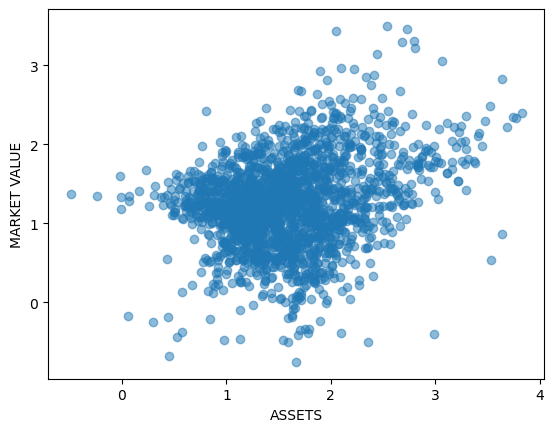

In [69]:
# Scatter plot between assets and market value column
import matplotlib.pyplot as plt
plt.scatter(np.log10(df['ASSETS']), np.log10(df['MARKET VALUE']), alpha=0.5)
plt.xlabel('ASSETS')
plt.ylabel('MARKET VALUE')
plt.show()

In [70]:
pearsons_corr = df["ASSETS"].corr(df["MARKET VALUE"], method="pearson")
pearsons_corr

0.15817813534744882

In [71]:
spearman_corr = df["ASSETS"].corr(df["MARKET VALUE"], method="spearman")
spearman_corr

0.21378342306415185

In [ ]:
# This tells us that: There is a low or moderate correlation between asset and market value on looking at the overall picture
# So, asset size doesn’t necessarily translate into market value

In [ ]:
# Let's deep dive into the industry level and check if this is still the case

In [ ]:
import statsmodels.api as sm

# Log-transform
df_log = df[(df["ASSETS"] > 0) & (df["MARKET VALUE"] > 0)]  # remove zeros
df_log["log_assets"] = np.log(df_log["ASSETS"])
df_log["log_market"] = np.log(df_log["MARKET VALUE"])


In [ ]:
industry_slopes = {}

for industry, group in df_log.groupby("INDUSTRY"):
    if len(group) > 5:  # only run if enough companies in that industry
        X = sm.add_constant(group["log_assets"])
        y = group["log_market"]
        model = sm.OLS(y, X).fit()
        slope = model.params["log_assets"]
        industry_slopes[industry] = slope

# Convert to DataFrame for easier sorting
industry_slopes_df = pd.DataFrame.from_dict(industry_slopes, orient="index", columns=["Slope"]).sort_values("Slope", ascending=False)

print(industry_slopes_df.head(10))   # top 10 industries
print()
print(industry_slopes_df.tail(10))

                                  Slope
Oil & Gas Operations           1.022398
Household & Personal Products  0.919542
Telecommunications Services    0.872851
Trading Companies              0.817531
Banking                        0.802362
Semiconductors                 0.767631
Utilities                      0.688489
Retailing                      0.647083
Materials                      0.636072
Drugs & Biotechnology          0.633872

                                  Slope
Consumer Durables              0.468928
Insurance                      0.454062
Food Markets                   0.449401
Capital Goods                  0.445453
Hotels, Restaurants & Leisure  0.347607
Media                          0.314479
Diversified Financials         0.210735
Chemicals                      0.206357
Construction                  -0.023278
Business Services & Supplies  -0.061305


Step 3: Interpret

High slope (>1) → market value grows faster than assets.

Slope ≈ 1 → market value grows roughly in line with assets.

Low slope (<1) → market value grows slower than assets.

This way, you can actually answer:
“Do investors reward large asset bases, and does that differ across industries?”

**How to Interpret Results**

Intercept (const): baseline scaling constant.

Slope (log_assets coefficient): elasticity of market value w.r.t. assets.

For example:

If slope ≈ 1.0 → market value grows proportionally with assets (investors fully reward asset growth).

If slope < 1.0 → market value grows slower than assets (common in asset-heavy industries like banks, utilities).

If slope > 1.0 → market value grows faster than assets (asset-light industries, tech, brand-heavy companies).


Suppose the regression gives: log_market = 0.8 * log_assets + constant
Then:

A 1% increase in assets → 0.8% increase in market value.

That would mean investors do reward asset growth, but not fully — they discount some industries with huge but low-return asset bases.

In [ ]:
# We can see that only the Oil & Gas Operations industry observes a slope of 1.022398 i.e. > 1. 
# Hence this shows that the market value grows faster than the assets

# The Construction and Business Services & Supplies have a negative slope. This tells us that ....

##### Question 2: Which companies/industries generate the highest return on equity or assets?

In [20]:
df.sort_values(by='ROA', ascending=False).head(10)

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY,ROA,REGION
1511,"1,511",Endo,Ireland,Drugs & Biotechnology,1.760,5.4600,4.680,1.640,Developed,3.102273,2.659091,1.166667,Europe
1951,"1,951",RattanIndia Power,India,Utilities,0.390,1.2900,1.140,0.667,Emerging,3.307692,2.923077,1.131579,Asia-Pacific
737,738,EXOR,Netherlands,Diversified Financials,1.930,29.5100,41.730,20.030,Developed,15.290155,21.621762,0.707165,Europe
46,47,NVIDIA,United States,Semiconductors,130.500,72.8800,111.600,2708.640,Developed,0.558467,0.855172,0.653047,North America
1378,"1,378",VeriSign,United States,IT Software & Services,1.570,0.7909,1.450,25.680,Developed,0.503758,0.923567,0.545448,North America
1861,"1,862",Americanas,Brazil,Retailing,2.670,1.5400,2.830,0.207,Emerging,0.576779,1.059925,0.544170,South America
1551,"1,551",Savola Group,Saudi Arabia,"Food, Drink & Tobacco",6.390,3.0300,5.690,2.440,Emerging,0.474178,0.890454,0.532513,MENA
1954,"1,955",Sichuan Biokin Pharmaceutical,China,Drugs & Biotechnology,0.807,0.5152,0.978,15.240,Emerging,0.638414,1.211896,0.526789,Asia-Pacific
1130,"1,131",Monolithic Power Systems,United States,Semiconductors,2.210,1.7900,3.620,27.950,Developed,0.809955,1.638009,0.494475,North America
1791,"1,792",Oi,Brazil,Telecommunications Services,0.590,1.7800,3.780,0.416,Emerging,3.016949,6.406780,0.470899,South America


In [ ]:
# Endo, a Drugs and Biotechnology company from Ireland tops the list.
# 30% of these companies have their HQs in US
# The list comprices of 50 : 50 ratio of developed and emerging market types
# Only Endo (Ireland, Drugs and Biotechnology) and RattanIndia Power (India, Utilities) have ROAs >1

##### Question 3: Are there firms with high market value but relatively low sales or profit → overvalued growth companies?


In [ ]:
# Let's compute 2 ratios:
# 1) Price-to-Sales (P/S) = Market Value / Sales
# 2) Price-to-Earnings (P/E) = Market Value / Profit

# We need to identify firms in the upper quartile of Market Value but in the lower quartile of Sales or Profit
# Such firms will have extreme P/S and P/E ratios and are called Growth Stocks

# Since there are records with negative profits, we will use P/S instead of P/E for such cases.

In [24]:
# Compute ratios safely
df["P_S"] = df["MARKET VALUE"] / df["SALES"].replace(0, np.nan)  # avoid div by 0
df["P_E"] = df["MARKET VALUE"] / df["PROFIT"].replace(0, np.nan)

In [67]:
# Flag high market value but low fundamentals
market_q4 = df["MARKET VALUE"].quantile(0.75)
sales_q1 = df["SALES"].quantile(0.25)
profit_q1 = df["PROFIT"].quantile(0.25)

In [26]:
df["Growth_Flag"] = (
    (df["MARKET VALUE"] >= market_q4) &
    ((df["SALES"] <= sales_q1) | (df["PROFIT"] <= profit_q1))
)

growth_companies = df[df["Growth_Flag"]]

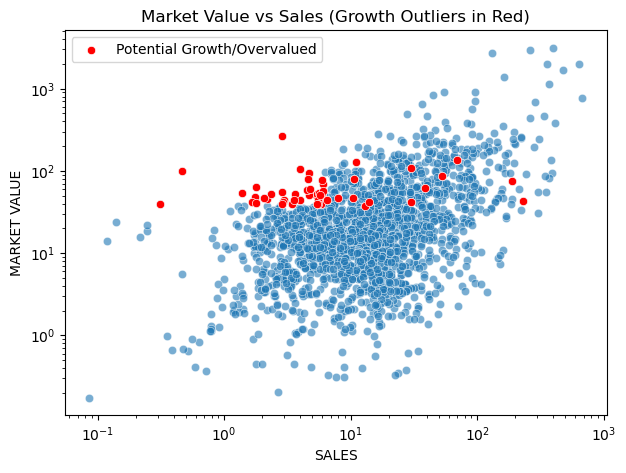

In [31]:
# Scatter plot Market Value vs Sales


plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="SALES", y="MARKET VALUE", alpha=0.6)
sns.scatterplot(data=growth_companies, x="SALES", y="MARKET VALUE", color="red", label="Potential Growth/Overvalued")
plt.xscale("log"); plt.yscale("log")
plt.title("Market Value vs Sales (Growth Outliers in Red)")
plt.legend()
plt.show()

In [68]:
# --- Define thresholds for "extreme" outliers ---
# Top 10% P/S or P/E
ps_threshold = df["P_S"].quantile(0.90)
pe_threshold = df["P_E"].quantile(0.90)

# Select extreme companies
outliers = df[(df["P_S"] >= ps_threshold) | (df["P_E"] >= pe_threshold)]

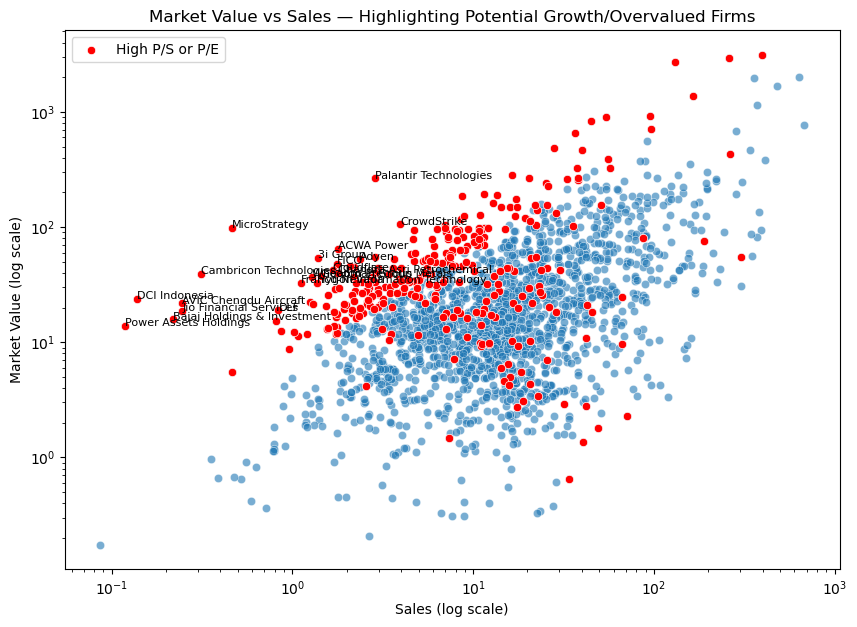

In [12]:
# --- Scatter Plot: Market Value vs Sales ---
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="SALES", y="MARKET VALUE", alpha=0.6)
sns.scatterplot(data=outliers, x="SALES", y="MARKET VALUE", color="red", label="High P/S or P/E")

# Add log scales
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sales (log scale)")
plt.ylabel("Market Value (log scale)")
plt.title("Market Value vs Sales — Highlighting Potential Growth/Overvalued Firms")

# Annotate outliers with company names

for _, row in outliers.sort_values(by='P_S', ascending=False).head(20).iterrows(): # annotating the top 20 firms
    plt.text(row["SALES"], row["MARKET VALUE"], row["NAME"], fontsize=8)

plt.legend()
plt.show()

In [69]:
growth_and_outlier_df = outliers[outliers['Growth_Flag'] == True]
growth_and_outlier_df.sort_values(by='P_S', ascending=False).reset_index().head(20)
# There are 45 companies in total, here are the top 20.

,index,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY,ROA,REGION,P_S,P_E,Growth_Flag,UnderValued
0,1183,1183.0,MicroStrategy,United States,IT Software & Services,0.463,-1.1700,25.840,98.14,Developed,-2.526998,55.809935,-0.045279,North America,211.965443,-83.880342,True,False
1,1692,1694.0,Cambricon Technologies,China,Semiconductors,0.312,0.0180,0.958,39.40,Emerging,0.057692,3.070513,0.018789,Asia-Pacific,126.282051,2188.888889,True,False
2,1347,1347.0,Palantir Technologies,United States,IT Software & Services,2.870,0.4622,6.340,264.51,Developed,0.161045,2.209059,0.072902,North America,92.163763,572.284725,True,False
3,698,699.0,3i Group,United Kingdom,Diversified Financials,1.390,5.3400,31.250,54.08,Developed,3.841727,22.482014,0.170880,Europe,38.906475,10.127341,True,False
4,1403,1404.0,ACWA Power,Saudi Arabia,Utilities,1.790,0.4683,15.240,64.25,Emerging,0.261620,8.513966,0.030728,MENA,35.893855,137.198377,True,False
5,1411,1412.0,FICO,United States,IT Software & Services,1.770,0.5443,1.710,47.67,Developed,0.307514,0.966102,0.318304,North America,26.932203,87.580378,True,False
6,1488,1490.0,CrowdStrike,United States,IT Software & Services,3.950,-0.0193,8.700,105.32,Developed,-0.004886,2.202532,-0.002218,North America,26.663291,-5456.994819,True,False
7,1669,1671.0,Cloudflare,United States,IT Software & Services,1.670,-0.0788,3.300,42.00,Developed,-0.047186,1.976048,-0.023879,North America,25.149701,-532.994924,True,False
8,1683,1685.0,Chandra Asri Petrochemical,Indonesia,Chemicals,1.780,-0.0690,5.660,40.09,Emerging,-0.038764,3.179775,-0.012191,Asia-Pacific,22.522472,-581.014493,True,False
9,1162,1163.0,Adyen,Netherlands,Banking,2.360,1.0000,11.830,52.50,Developed,0.423729,5.012712,0.084531,Europe,22.245763,52.500000,True,False


In [29]:
hq_group = growth_and_outlier_df.groupby(['HEADQUARTERS']).agg(Count = ('RANK', 'count')).reset_index()
hq_group

,HEADQUARTERS,Count
0,China,6
1,Hong Kong,1
2,Indonesia,2
3,Japan,1
4,Netherlands,1
5,Saudi Arabia,1
6,United Kingdom,2
7,United States,31


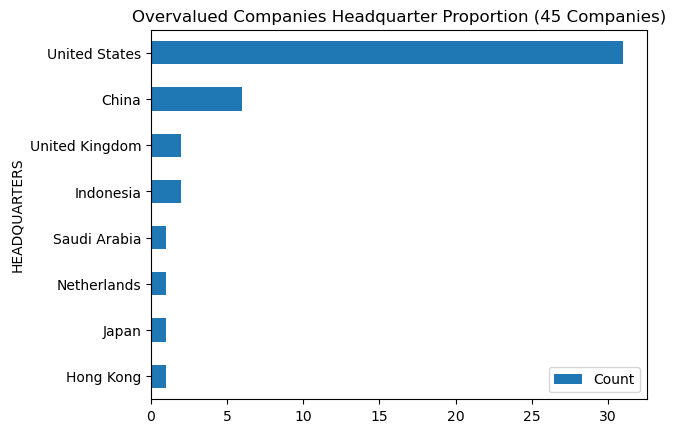

In [45]:
# If you want, you can generate a bar chart to show the industry or head quarters proportion

# Create a horizontal bar chart
hq_group.sort_values(by='Count', ascending=True).plot.barh(x='HEADQUARTERS', y='Count', title='Overvalued Companies Headquarter Proportion (45 Companies)')
# plt.title('Overvalued Companies Headquarter Proportion')
# plt.ylabel('') # Hides the default y-label
plt.show()

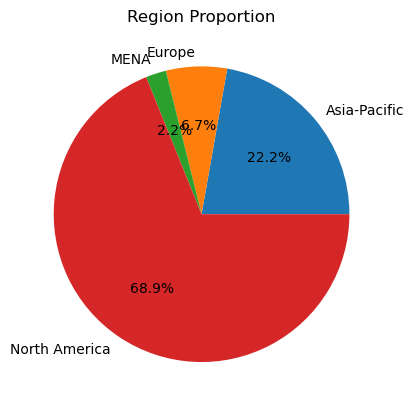

In [70]:
# Pie chart to show Proportion of undervalued companies by Region
region_grp = growth_and_outlier_df.groupby(['REGION']).agg(Count= ('RANK','count')).reset_index()
plt.pie(labels = region_grp['REGION'], x = region_grp.Count, autopct='%1.1f%%')
plt.title("Region Proportion") 
plt.show()


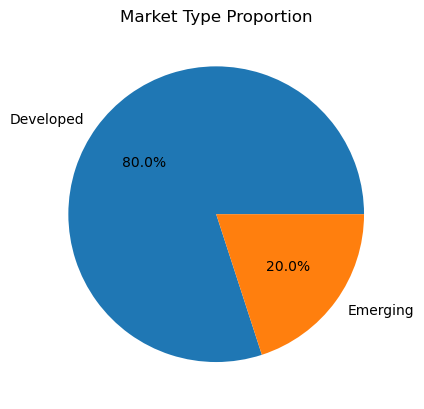

In [46]:
market_type_grp = growth_and_outlier_df.groupby(['MARKET TYPE']).agg(Count= ('RANK','count')).reset_index()
plt.pie(labels = market_type_grp['MARKET TYPE'], x = market_type_grp.Count, autopct='%1.1f%%')
plt.title("Market Type Proportion") 
plt.show()


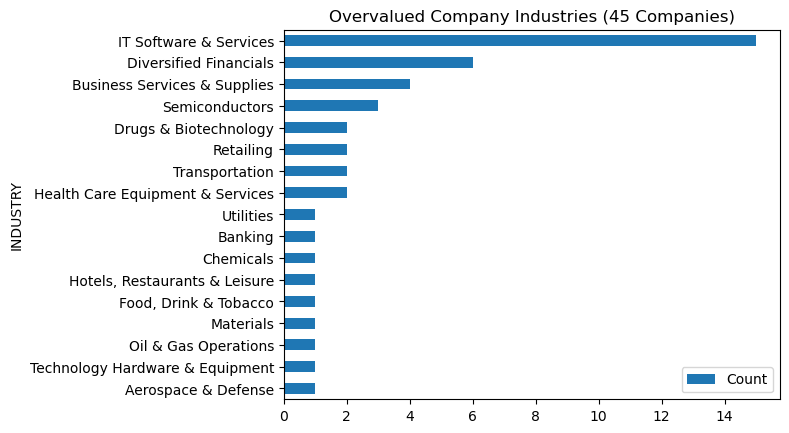

In [ ]:
industry_grp = growth_and_outlier_df.groupby(['INDUSTRY']).agg(Count= ('RANK','count')).reset_index()
industry_grp.sort_values(by='Count', ascending=True).plot.barh(x='INDUSTRY', y='Count', title='Overvalued Company Industries (45 Companies)')
plt.show()

In [10]:
df.to_csv("Analysis_ready_data.csv", index=False)

##### Question 4: Which companies look undervalued (high profit/assets but relatively low market value)?

In [47]:
df.head(1)

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY,ROA,REGION,P_S,P_E,Growth_Flag,UnderValued
0,1.0,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.8,Developed,0.2082,15.284837,0.013621,North America,2.377328,11.418464,False,False


In [56]:
# High ROA or Profit Margin + Low Market Value = Undervalued companies
# Flag high market value but low fundamentals
market_q1 = df["MARKET VALUE"].quantile(0.25)
roa_q3 = df["ROA"].quantile(0.75)
profit_q3 = df["PROFIT MARGIN"].quantile(0.75)

In [57]:
# Flag all the companies
df['UnderValued'] = (
    (df['MARKET VALUE'] <= market_q1) & 
    ((df['ROA'] >= roa_q3) | (df['PROFIT MARGIN'] >= profit_q3)))
underValuedCompanies = df['UnderValued']

underValuedCompanies = df[df['UnderValued']]

In [58]:
# --- Define thresholds for "extreme" outliers ---
# Bottom 10% P/S or P/E : low P/S or P/E = cheap valuation.
ps_threshold = df["P_S"].quantile(0.10)
pe_threshold = df["P_E"].quantile(0.10)

# Select extreme companies
outliers = df[(df["P_S"] <= ps_threshold) | (df["P_E"] <= pe_threshold)]

In [60]:
under_valued_outlier_df = outliers[outliers['UnderValued'] == True]
under_valued_outlier_df.sort_values(by='P_S', ascending=False).reset_index().shape

(30, 18)

In [62]:
# Let us group by Country and Industry
hq_group = under_valued_outlier_df.groupby(['HEADQUARTERS']).agg(Count = ('RANK', 'count')).sort_values(by='Count', ascending=False).reset_index()
hq_group

,HEADQUARTERS,Count
0,Brazil,5
1,United Kingdom,3
2,Indonesia,3
3,South Korea,3
4,China,2
5,Lebanon,1
6,Taiwan,1
7,Switzerland,1
8,Saudi Arabia,1
9,Mexico,1


In [ ]:
# We can see that there is much mode diversity for where the undervalued companies have their HQs, the most being from Brazil

<Axes: title={'center': 'Undervalued Companies Headquarter Proportion (30 Companies)'}, ylabel='HEADQUARTERS'>

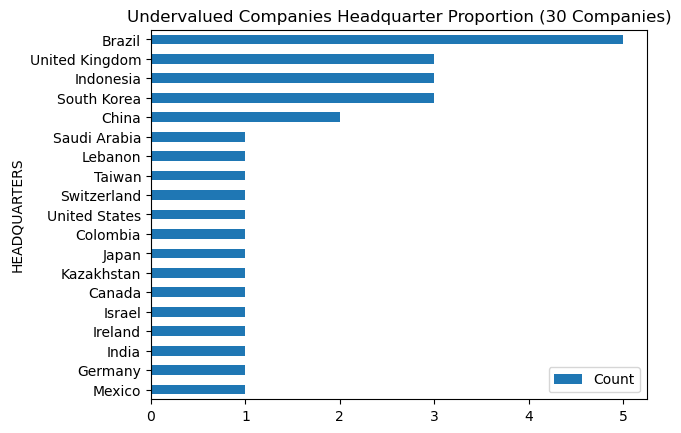

In [63]:
hq_group.sort_values(by='Count', ascending=True).plot.barh(x='HEADQUARTERS', y='Count', title='Undervalued Companies Headquarter Proportion (30 Companies)')

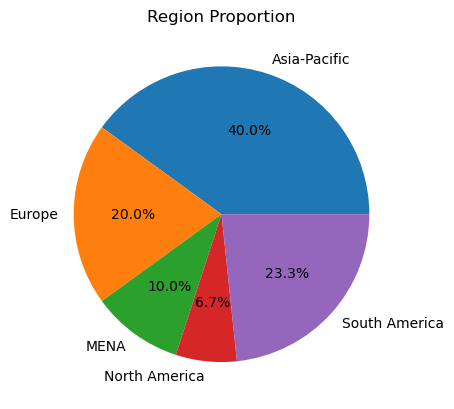

In [65]:
# Pie chart to show Proportion of undervalued companies by Region
region_grp = under_valued_outlier_df.groupby(['REGION']).agg(Count= ('RANK','count')).reset_index()
plt.pie(labels = region_grp['REGION'], x = region_grp.Count, autopct='%1.1f%%')
plt.title("Region Proportion") 
plt.show()


In [ ]:
# Compare this with the overvalued pie chart (Focus on North America)

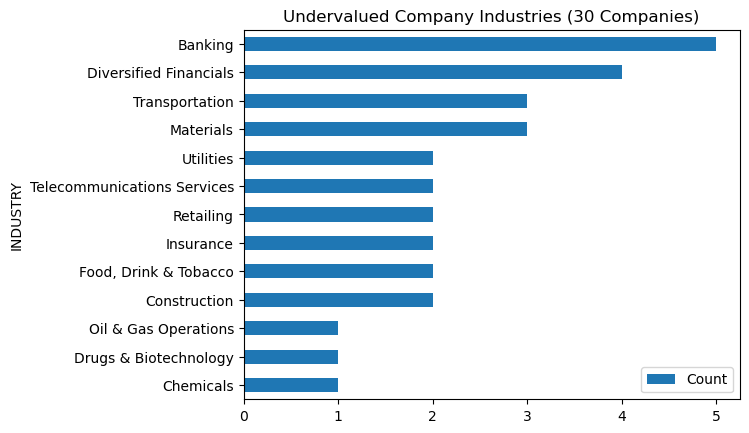

In [64]:
industry_grp = under_valued_outlier_df.groupby(['INDUSTRY']).agg(Count= ('RANK','count')).reset_index()
industry_grp.sort_values(by='Count', ascending=True).plot.barh(x='INDUSTRY', y='Count', title='Undervalued Company Industries (30 Companies)')
plt.show()

In [ ]:
# Banking and Diversified Financial Industries have the highest number of undervalued companies

In [ ]:
# Insights: There are 30 undervalued companies

#### 4. Rank & Valuation Dynamics

##### Question 1: What financial metrics best explain a company’s rank (e.g., is rank driven more by sales, profit, or market value)?


In [ ]:
# # Let's pick a subset of the dataset taking the finincial metric columns
corr_df = df[['SALES', 'PROFIT', 'ASSETS', 'MARKET VALUE']]

# # We will now standardize these columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(corr_df)
# Add the rank column to the scaled df
scaled_df = pd.DataFrame(scaled_df, columns=['SALES', 'PROFIT', 'ASSETS', 'MARKET VALUE']).join(df['RANK'])

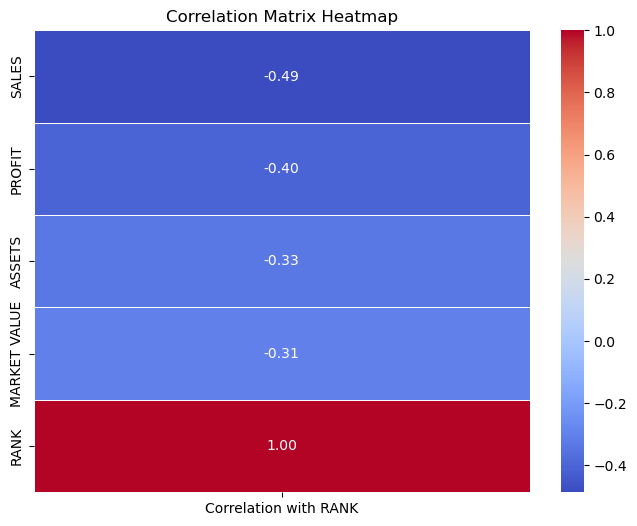

In [ ]:
# Rank is an Ordinal Feature - the lower, the better
# So correlations with the company rank will be negative

# Let's build a correlation matrix with Rank
correlation_with_rank = scaled_df.corrwith(scaled_df['RANK']).to_frame(name='Rank v/s Metrics')

# # Visualizing with the HeatMap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_rank, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Insights: Sales has the most negative correlation with the RANK, this tells us that it is the best financial metrics that mirrors a company's rank

##### Question 2: Are top-ranked companies concentrated in a few industries or countries?


In [11]:
df = pd.read_csv("Analysis_ready_data.csv")

In [21]:
df.head(1)

,RANK,NAME,HEADQUARTERS,INDUSTRY,SALES,PROFIT,ASSETS,MARKET VALUE,MARKET TYPE,PROFIT MARGIN,ASSET INTENSITY,ROA,REGION,P_S,P_E,Growth_Flag
0,1.0,JPMorganChase,United States,Banking,285.11,59.36,4357.86,677.8,Developed,0.2082,15.284837,0.013621,North America,2.377328,11.418464,False


In [25]:
# Let's look at the Top 20 countries
# Let's create a subset for it first
df_top20 = df.iloc[:20,:]

# Now let's group by the industry and country
industry_grp = df_top20.groupby(['INDUSTRY']).agg(Company_count = ('RANK', 'count')).sort_values(by='Company_count', ascending=True).reset_index()

country_grp = df_top20.groupby(['HEADQUARTERS']).agg(Company_count = ('RANK', 'count')).reset_index()


In [26]:
industry_grp

,INDUSTRY,Company_count
0,Consumer Durables,1
1,Diversified Financials,1
2,Retail and Wholesale,1
3,Retailing,1
4,IT Software & Services,2
5,Insurance,2
6,Oil & Gas Operations,2
7,Technology Hardware & Equipment,2
8,Banking,8


In [27]:
country_grp

,HEADQUARTERS,Company_count
0,China,4
1,Japan,1
2,Saudi Arabia,1
3,South Korea,1
4,United Kingdom,1
5,United States,12


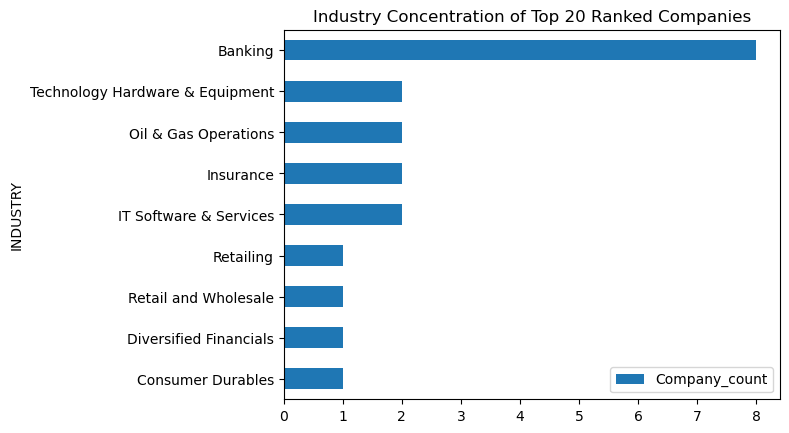

In [39]:
# Let's Visualize

# Horizontal Bar chart for the industry
industry_grp.plot.barh(x='INDUSTRY', y='Company_count', title='Industry Concentration of Top 20 Ranked Companies')
plt.show()

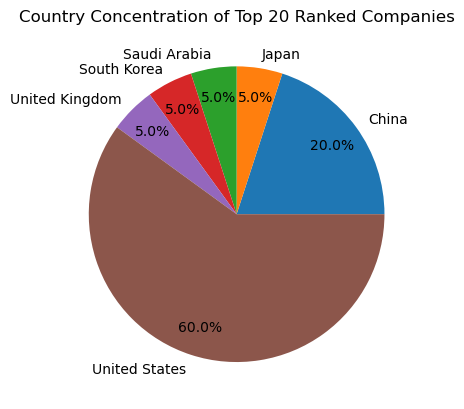

In [38]:
# Pie chart for country
plt.pie(labels = country_grp['HEADQUARTERS'], x = country_grp.Company_count, autopct='%1.1f%%', pctdistance= 0.8, labeldistance=1.1)
plt.title("Country Concentration of Top 20 Ranked Companies") 
plt.show()

In [ ]:
# Insights: 8/20 ~ 40% of the companies falling under the Top 20 Ranked Companies belong to the Banking Industry 
# 60% of the Top 20 Ranked Companies have their HQs in the US.

##### Question 3: Do the top 10% ranked companies show fundamentally different metrics compared to the rest?

# Code Cleaning TODOs:
1) Make a function for group by, pie chart and horizontal bar chart
2) Write the insights in Markdown cells
3) Rename Growth Flag column